### Exploratory data analysis for Semantic Segmentation van MRI breinscans 

### Imports

In [24]:
import numpy as np
import nibabel as nib 
import random
import glob 
import tensorflow as tf
import keras.utils
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

### Laad de data

Er zijn al training en validation data beschikbaar gemaakt en heeft de volgende description:

- T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
- T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
- T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
- FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

In [25]:
TRAIN_DATASET_PATH = '../data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

We gaan eerst de data testen met met 1 directory. We gebruiken nib.load, dit laad de .nii bestanden in met meerdere "slices" in  3D. Deze worden omgezet in numbpy arrays om de data beter beschikbaar te maken met het scalen. Het resulterende array heeft (240, 240, 115). Dat is dus een slice in een 2D beeld (240 x 240) en het aantal slices in een 3D stack (115). 

In [26]:
# Load the .nii files and shape it to be numpy array.
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 

print("Data type:", test_image_flair.dtype)
print("Shape:", test_image_flair.shape)
print("Min:", test_image_flair.min(), "Max:", test_image_flair.max())

Data type: float64
Shape: (240, 240, 155)
Min: 0.0 Max: 1854.603271484375


De data is aangeleverd in de 3D vorm en moet dus nog gescaled worden. Hierom moeten we de data eerst reshapen naar 2D (-1, 1) om de scaler te gebruiken. Dan schaalen we de data door MinMaxScaler te gebruiken. Tot slot reshapen we terug naar de originele 3D vorm. Dit zal worden herhaald voor alle modaliteiten (flair, t1, t1ce, t2). De masks daarintegen moeten niet gescaled worden, echter moeten de labels wel aangepast worden. Geen enkele pixel wordt assigned aan label 3, dus die wordt vervangen met label 4. 

In [27]:
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

[0 1 2 4]
[0 1 2 3]


### Visualisatie

Laten we nu de images bekijken voor 1 slice:

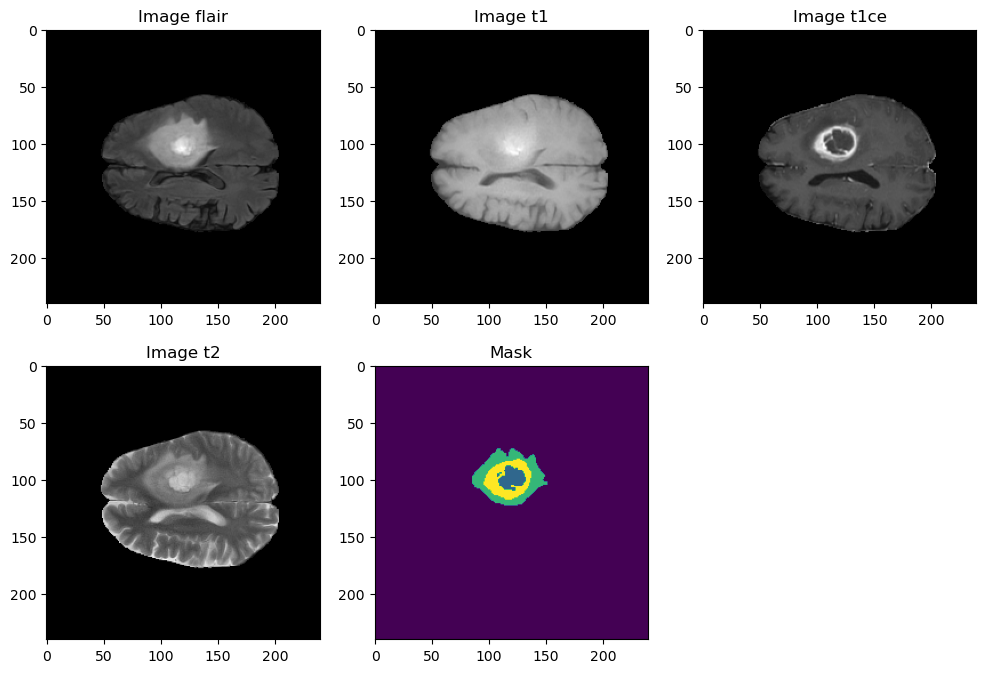

In [28]:
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

De informatie waar we naar zoeken is het masker label (de de kleuren geven een tumor aan). Als de visualisations opnieuw geladen worden krijg je niet altijd een label terug. Dit betekent dat er een hoop data is die nutteloos is en gecropped kan worden. We zullen ook t1 weglaten uit onze dataset omdat deze geen extra informatie geeft.

### Cropping 

Nu hebben we 3 aparte images Flair, T1CE en T2, laten we die nu samenvoegen 1 multichannel image. We doen dit nog steeds voor 1 directory, zodat we het later op kunnen schalen. 

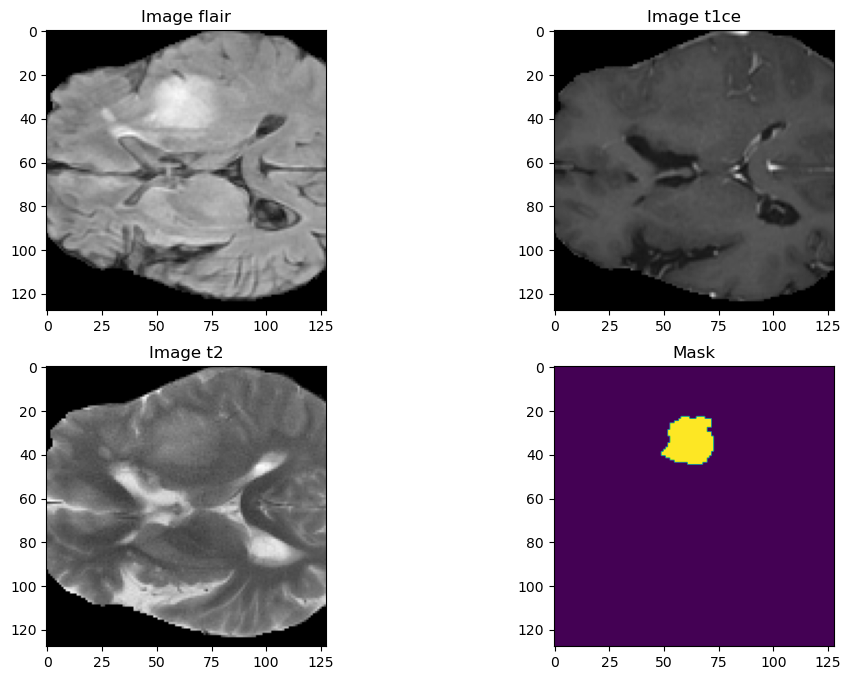

In [29]:
#Combine t1ce, t2, and flair into single multichannel image
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

De nutteloze data is er nu uit gecroppped. 

### Save de data

We moeten de data nu opslaan nu het gescaled is om de traing makkelijk te laten verlopen. Er zijn twee manieren om de data op te slaan. Een als een tiff file en een als np array. Het lijkt het beste om de data op te slaan als een np array omdat als er channels zijn met meer dan 3, het niet meer werkt. 

In [32]:
# Save as tiff file
#imsave('..data/BraTS2020_TrainingData/combined255.tif', combined_x)
# Save as np file
np.save('../data/BraTS2020_TrainingData/combined255.npy', combined_x)

# Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')
my_img=np.load('../data/BraTS2020_TrainingData/combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)

De numpy file is succesvol aangemaakt, er kan nu gewerkt worden aan de volledige datset. 